In [1]:
# https://pytorch.org/docs/stable/optim.html
# https://pytorch.org/docs/stable/optim.html#algorithms
# https://pytorch.org/docs/stable/nn.html#loss-functions
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
# https://pytorch.org/docs/stable/nn.init.html
# 

In [19]:
# Import necessary libraries
import torch
import torch.nn as nn                    # For building neural networks
import torch.optim as optim              # For optimization algorithms
import torch.nn.functional as F          # For activation functions and other utilities
from torchvision import datasets, transforms  # For loading and transforming datasets
from torch.utils.data import DataLoader  # For data loading and batching
import matplotlib.pyplot as plt          # For plotting
import numpy as np

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [20]:
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])

In [21]:
# Download and load the training data
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)

# Download and load the test data
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

In [22]:
# Define data loaders for batching and shuffling
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define the classes in the Fashion MNIST dataset
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
]

In [35]:
# import matplotlib.pyplot as plt
# import numpy as np
# from torchvision import datasets, transforms

# # Define transformations for the data
# transform = transforms.Compose([
#     transforms.ToTensor(),                # Convert images to PyTorch tensors
#     transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
# ])

# # Download and load the training data
# train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# # Download and load the test data
# test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# # Define the classes in the Fashion MNIST dataset
# classes = [
#     'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#     'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
# ]

# Display a few images from the training dataset
def show_images(dataset, num_images=8, title='Training Images'):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(title, fontsize=15)
    for idx in range(num_images):
        ax = fig.add_subplot(2, 4, idx + 1, xticks=[], yticks=[])
        image, label = dataset[idx]
        image = image / 2 + 0.5  # Unnormalize the image
        np_image = image.numpy()
        plt.imshow(np.transpose(np_image, (1, 2, 0)), cmap='gray')
        ax.set_title(classes[label])

    plt.tight_layout()
    plt.show()


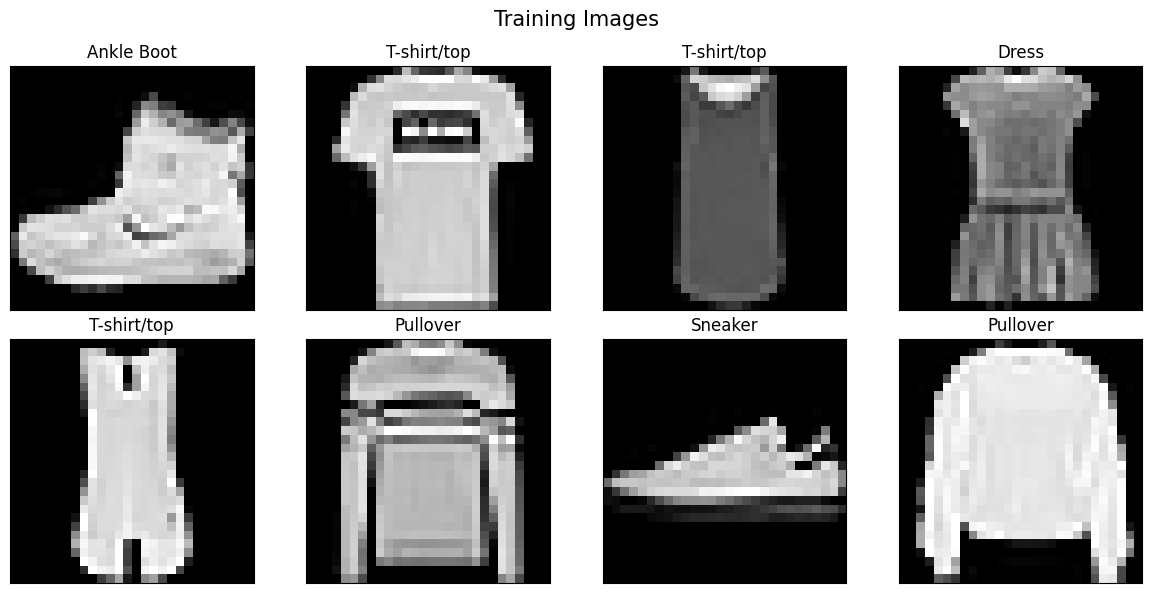

In [24]:
# Display images from the training dataset
show_images(train_dataset, num_images=8, title='Training Images')

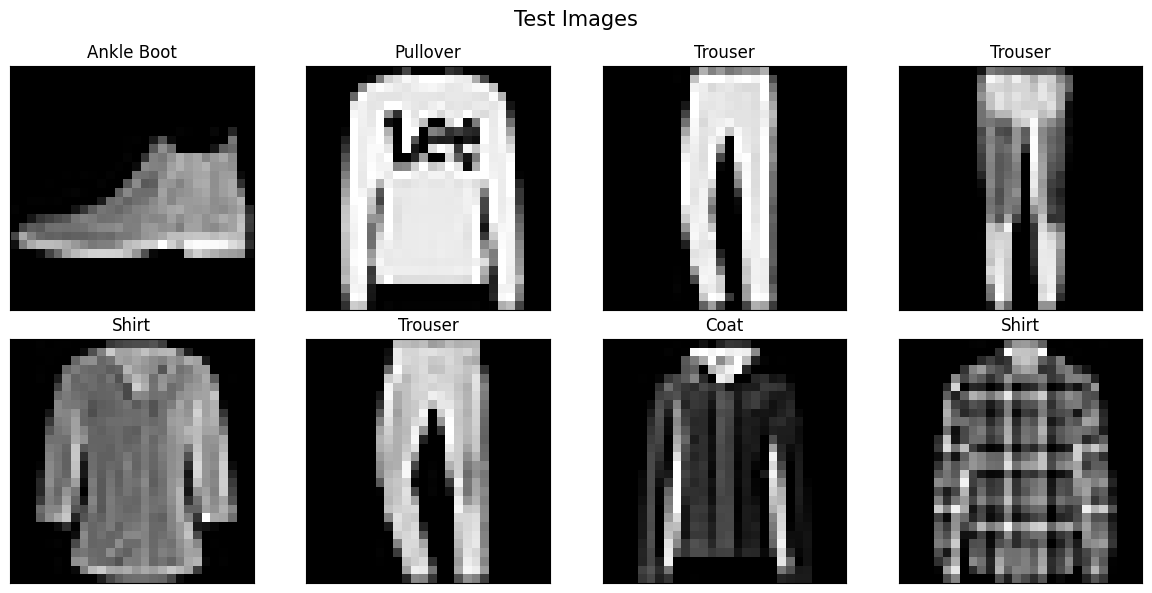

In [25]:
# Display images from the test dataset
show_images(test_dataset, num_images=8, title='Test Images')

In [5]:
# Define the CNN model by subclassing nn.Module
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize the base class
        # Convolutional layer 1: Input channels = 1 (grayscale), Output channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Convolutional layer 2: Input channels = 16, Output channels = 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling layer: Reduces spatial dimensions
        self.pool = nn.MaxPool2d(2, 2)
        # Fully connected layer 1
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        # Fully connected layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 10)
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Convolutional layer 1 followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Convolutional layer 2 followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        # Apply dropout
        x = self.dropout(x)
        # Fully connected layer 1 with ReLU activation
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

In [6]:
# Instantiate the model and move it to the device (CPU or GPU)
model = CNNModel().to(device)

# Define the loss function (Cross-Entropy Loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train
num_epochs = 10

# Lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            # Accumulate validation loss
            val_running_loss += val_loss.item()
            
            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()
    
    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(test_loader)
    val_epoch_accuracy = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}\n')

Epoch [1/10]
Training Loss: 0.5395, Training Accuracy: 0.8034
Validation Loss: 0.4161, Validation Accuracy: 0.8466

Epoch [2/10]
Training Loss: 0.3597, Training Accuracy: 0.8697
Validation Loss: 0.3332, Validation Accuracy: 0.8771

Epoch [3/10]
Training Loss: 0.3109, Training Accuracy: 0.8853
Validation Loss: 0.3057, Validation Accuracy: 0.8881

Epoch [4/10]
Training Loss: 0.2855, Training Accuracy: 0.8935
Validation Loss: 0.2926, Validation Accuracy: 0.8900

Epoch [5/10]
Training Loss: 0.2625, Training Accuracy: 0.9023
Validation Loss: 0.2787, Validation Accuracy: 0.9003

Epoch [6/10]
Training Loss: 0.2481, Training Accuracy: 0.9085
Validation Loss: 0.2892, Validation Accuracy: 0.8935

Epoch [7/10]
Training Loss: 0.2344, Training Accuracy: 0.9125
Validation Loss: 0.2580, Validation Accuracy: 0.9075

Epoch [8/10]
Training Loss: 0.2236, Training Accuracy: 0.9176
Validation Loss: 0.2553, Validation Accuracy: 0.9060

Epoch [9/10]
Training Loss: 0.2120, Training Accuracy: 0.9208
Validation

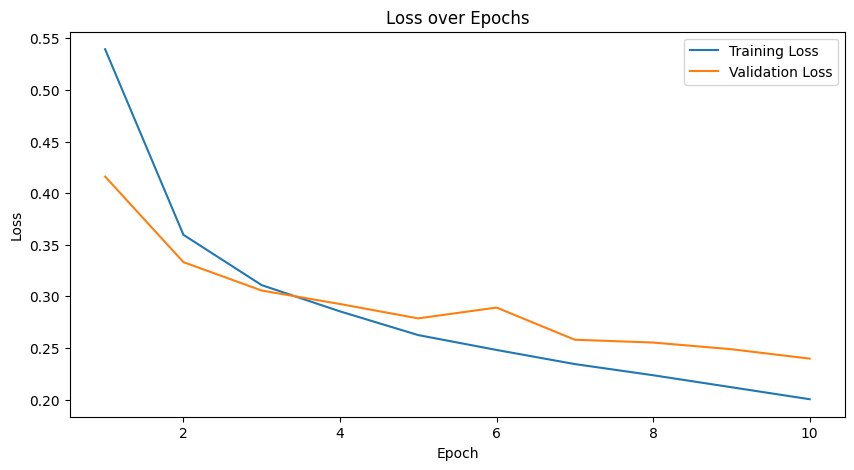

In [7]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

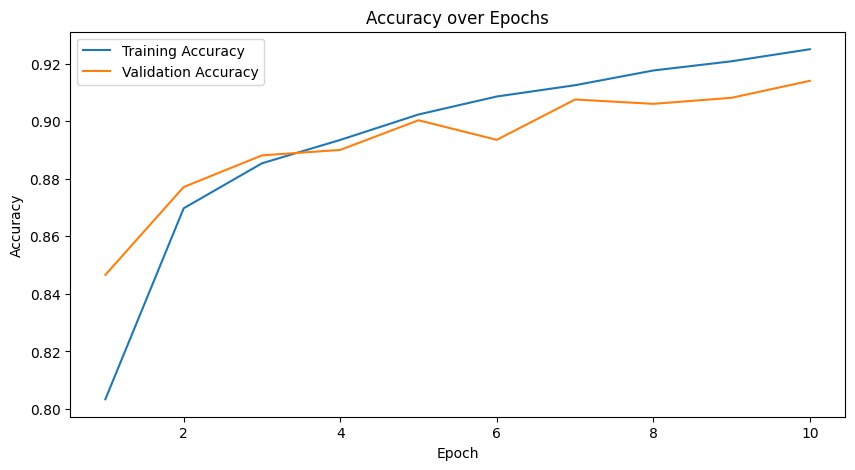

In [8]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

In [9]:
# Test the model on a few test images
import numpy as np

In [10]:
# Get some random test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

# Predict the classes
model.eval()
outputs = model(images)
_, predicted = torch.max(outputs, 1)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
# Move images and labels to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

In [ ]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Show images and predictions
fig = plt.figure(figsize=(12, 8))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(f'Predicted: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}')
plt.show()

# Implementing Hyperparameter Tuning in PyTorch
While PyTorch doesn't have a built-in hyperparameter tuning module like Keras's GridSearchCV, you can implement it using loops or utilize external libraries designed for this purpose.

## Option 1: Manual Implementation with Loops
You can create nested loops to iterate over possible values of hyperparameters.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

# Define the hyperparameters to search over
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]
num_epochs_list = [10, 20]

best_accuracy = 0.0
best_params = {}

# Iterate over all combinations of learning rates, batch sizes, and number of epochs
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in num_epochs_list:
            print(f'Training with lr={lr}, batch_size={batch_size}, num_epochs={num_epochs}')
            
            # Update DataLoader with the current batch_size
            train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model, criterion, and optimizer
            model = CNNModel().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Training loop
            for epoch in range(num_epochs):
                model.train()  # Set the model to training mode
                running_loss = 0.0
                correct = 0
                total = 0
                
                for images, labels in train_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    
                    # Accumulate training metrics
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                
                # Optionally, log the training accuracy for this epoch
                epoch_accuracy = correct / total
                print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {epoch_accuracy:.4f}')
            
            # Validation step
            model.eval()  # Set the model to evaluation mode
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for val_images, val_labels in test_loader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    
                    val_outputs = model(val_images)
                    val_loss = criterion(val_outputs, val_labels)
                    
                    val_running_loss += val_loss.item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total += val_labels.size(0)
                    val_correct += (val_predicted == val_labels).sum().item()
            
            # Calculate validation accuracy for this set of hyperparameters
            val_accuracy = val_correct / val_total
            print(f'Validation Accuracy: {val_accuracy:.4f}')
            
            # Check if this combination is the best one
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs
                }

# Output the best validation accuracy and corresponding hyperparameters
print(f'Best Validation Accuracy: {best_accuracy:.4f}')
print(f'Best Hyperparameters: {best_params}')


Training with lr=0.001, batch_size=32, num_epochs=10
Epoch [1/10], Training Loss: 0.4585, Training Accuracy: 0.8325
Epoch [2/10], Training Loss: 0.3117, Training Accuracy: 0.8843
Epoch [3/10], Training Loss: 0.2704, Training Accuracy: 0.8993
Epoch [4/10], Training Loss: 0.2405, Training Accuracy: 0.9105



KeyboardInterrupt


KeyboardInterrupt



#### Considerations:

- This method is simple but can be computationally expensive.
- You need to ensure that the training and validation code is correctly implemented within the loops.
- Be cautious with resources; extensive searches can consume a lot of time and computational power.

## Option 2: Using Hyperparameter Optimization Libraries
Several libraries can help automate hyperparameter tuning with advanced features:

### Optuna

- An automatic hyperparameter optimization framework.
- Supports efficient sampling and pruning algorithms.

In [13]:
# !pip install optuna

In [17]:
import optuna
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader

def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 10, 30)
    
    # Update DataLoader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, criterion, and optimizer
    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accumulate training metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate average training loss and accuracy for the epoch (optional for logging)
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        
        # Validation step
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        
        # Calculate validation accuracy for this epoch
        val_epoch_accuracy = val_correct / val_total
        
        # Logging information (optional)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}')
        print(f'Validation Loss: {val_running_loss / len(test_loader):.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    
    # Return the validation accuracy as the metric to be maximized
    return val_epoch_accuracy

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Display the best trial
print('Best trial:')
trial = study.best_trial
print(f'  Validation Accuracy: {trial.value}')
print('  Hyperparameters: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-09-23 13:02:31,792] A new study created in memory with name: no-name-8b290e67-bd9c-4c10-8613-f1c062992e5f


Epoch [1/25], Training Loss: 0.8916, Training Accuracy: 0.7086
Validation Loss: 0.5487, Validation Accuracy: 0.8035
Epoch [2/25], Training Loss: 0.5049, Training Accuracy: 0.8180
Validation Loss: 0.4612, Validation Accuracy: 0.8361
Epoch [3/25], Training Loss: 0.4469, Training Accuracy: 0.8401
Validation Loss: 0.4201, Validation Accuracy: 0.8472
Epoch [4/25], Training Loss: 0.4157, Training Accuracy: 0.8529
Validation Loss: 0.3936, Validation Accuracy: 0.8601
Epoch [5/25], Training Loss: 0.3928, Training Accuracy: 0.8601
Validation Loss: 0.3835, Validation Accuracy: 0.8633
Epoch [6/25], Training Loss: 0.3793, Training Accuracy: 0.8640
Validation Loss: 0.3761, Validation Accuracy: 0.8633
Epoch [7/25], Training Loss: 0.3672, Training Accuracy: 0.8689
Validation Loss: 0.3574, Validation Accuracy: 0.8749
Epoch [8/25], Training Loss: 0.3543, Training Accuracy: 0.8720
Validation Loss: 0.3446, Validation Accuracy: 0.8759
Epoch [9/25], Training Loss: 0.3444, Training Accuracy: 0.8771
Validatio

[I 2024-09-23 13:06:52,954] Trial 0 finished with value: 0.9033 and parameters: {'lr': 0.00011838591301416305, 'batch_size': 128, 'num_epochs': 25}. Best is trial 0 with value: 0.9033.


Epoch [25/25], Training Loss: 0.2534, Training Accuracy: 0.9079
Validation Loss: 0.2701, Validation Accuracy: 0.9033
Epoch [1/11], Training Loss: 0.4239, Training Accuracy: 0.8458
Validation Loss: 0.3166, Validation Accuracy: 0.8885
Epoch [2/11], Training Loss: 0.2911, Training Accuracy: 0.8934
Validation Loss: 0.2752, Validation Accuracy: 0.8981
Epoch [3/11], Training Loss: 0.2507, Training Accuracy: 0.9063
Validation Loss: 0.2589, Validation Accuracy: 0.9041
Epoch [4/11], Training Loss: 0.2226, Training Accuracy: 0.9166
Validation Loss: 0.2626, Validation Accuracy: 0.9076
Epoch [5/11], Training Loss: 0.2092, Training Accuracy: 0.9211
Validation Loss: 0.2469, Validation Accuracy: 0.9064
Epoch [6/11], Training Loss: 0.1921, Training Accuracy: 0.9278
Validation Loss: 0.2406, Validation Accuracy: 0.9144
Epoch [7/11], Training Loss: 0.1807, Training Accuracy: 0.9325
Validation Loss: 0.2362, Validation Accuracy: 0.9168
Epoch [8/11], Training Loss: 0.1706, Training Accuracy: 0.9354
Validati

[I 2024-09-23 13:08:57,946] Trial 1 finished with value: 0.9193 and parameters: {'lr': 0.0027239108725473013, 'batch_size': 64, 'num_epochs': 11}. Best is trial 1 with value: 0.9193.


Epoch [11/11], Training Loss: 0.1431, Training Accuracy: 0.9455
Validation Loss: 0.2513, Validation Accuracy: 0.9193
Epoch [1/30], Training Loss: 0.6502, Training Accuracy: 0.7745
Validation Loss: 0.4529, Validation Accuracy: 0.8391
Epoch [2/30], Training Loss: 0.4315, Training Accuracy: 0.8465
Validation Loss: 0.4244, Validation Accuracy: 0.8423
Epoch [3/30], Training Loss: 0.3867, Training Accuracy: 0.8624
Validation Loss: 0.3706, Validation Accuracy: 0.8704
Epoch [4/30], Training Loss: 0.3597, Training Accuracy: 0.8713
Validation Loss: 0.3522, Validation Accuracy: 0.8709
Epoch [5/30], Training Loss: 0.3382, Training Accuracy: 0.8788
Validation Loss: 0.3268, Validation Accuracy: 0.8852
Epoch [6/30], Training Loss: 0.3195, Training Accuracy: 0.8843
Validation Loss: 0.3152, Validation Accuracy: 0.8880
Epoch [7/30], Training Loss: 0.3044, Training Accuracy: 0.8903
Validation Loss: 0.3084, Validation Accuracy: 0.8894
Epoch [8/30], Training Loss: 0.2918, Training Accuracy: 0.8942
Validati

[W 2024-09-23 13:12:28,575] Trial 2 failed with parameters: {'lr': 0.00012385939591707225, 'batch_size': 32, 'num_epochs': 30} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_930/1237912124.py", line 29, in objective
    for images, labels in train_loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_util

# Practical Tips for Hyperparameter Tuning

- Start with Reasonable Defaults:-- Begin with commonly used values (e.g., lr=0.001 for Adam, batch_size=64).
-- Adjust based on observed performance.

- Adjust One Hyperparameter at a Time:
-- Change one hyperparameter while keeping others constant to understand its impact.

- Use Validation Data:
-- Always evaluate hyperparameter choices on a validation set, not the training data.

- Monitor Training Progress:
-- Plot loss and accuracy curves to identify overfitting or underfitting.

- Consider Learning Rate Schedulers:
-- Use learning rate schedulers to adjust the learning rate during training.

In [29]:
import torchvision.transforms as transforms

# Define the data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),        # Randomly flip images horizontally
    transforms.RandomRotation(degrees=30),         # Randomly rotate images by up to 30 degrees
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Randomly crop and resize images
    transforms.ToTensor(),                         # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))           # Normalize images to [-1, 1]
])

# Transforms for the test set (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## Implementing LeNet Architecture
LeNet is one of the earliest convolutional neural networks, consisting of:

- Two convolutional layers
- Two pooling layers
- Three fully connected layers

In [30]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

# Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [31]:
# Load the datasets with data augmentation
train_dataset = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=test_transform)

# Define DataLoaders
batch_size = 64

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Define the LeNet model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # First convolutional layer (input channels = 1, output channels = 6)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        # Second convolutional layer (input channels = 6, output channels = 16)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # Adjusted for 28x28 images
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classes in Fashion MNIST

    def forward(self, x):
        # Convolutional layer 1 with ReLU activation and pooling
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.avg_pool2d(x, 2)
        # Convolutional layer 2 with ReLU activation and pooling
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.avg_pool2d(x, 2)
        # Flatten the tensor
        x = x.view(-1, 16 * 4 * 4)
        # Fully connected layers with ReLU activation
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        # Output layer (no activation needed as CrossEntropyLoss applies Softmax)
        x = self.fc3(x)
        return x

In [33]:
# Instantiate the model and move it to the device
model = LeNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  # Predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation step
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Forward pass
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            # Accumulate validation loss
            val_running_loss += val_loss.item()

            # Calculate validation accuracy
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Calculate average validation loss and accuracy
    val_epoch_loss = val_running_loss / len(test_loader)
    val_epoch_accuracy = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.4f}')
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.4f}\n')

Epoch [1/10]
Train Loss: 0.9375, Train Acc: 0.6408
Val Loss: 0.6633, Val Acc: 0.7397

Epoch [2/10]
Train Loss: 0.6857, Train Acc: 0.7346
Val Loss: 0.6314, Val Acc: 0.7556

Epoch [3/10]
Train Loss: 0.6158, Train Acc: 0.7635
Val Loss: 0.5689, Val Acc: 0.7844

Epoch [4/10]
Train Loss: 0.5769, Train Acc: 0.7806
Val Loss: 0.5269, Val Acc: 0.7980

Epoch [5/10]
Train Loss: 0.5468, Train Acc: 0.7912
Val Loss: 0.5592, Val Acc: 0.7845

Epoch [6/10]
Train Loss: 0.5274, Train Acc: 0.7992
Val Loss: 0.4774, Val Acc: 0.8134

Epoch [7/10]
Train Loss: 0.5103, Train Acc: 0.8066
Val Loss: 0.4826, Val Acc: 0.8154

Epoch [8/10]
Train Loss: 0.4966, Train Acc: 0.8108
Val Loss: 0.4801, Val Acc: 0.8159

Epoch [9/10]
Train Loss: 0.4814, Train Acc: 0.8185
Val Loss: 0.4588, Val Acc: 0.8225

Epoch [10/10]
Train Loss: 0.4707, Train Acc: 0.8224
Val Loss: 0.4148, Val Acc: 0.8441



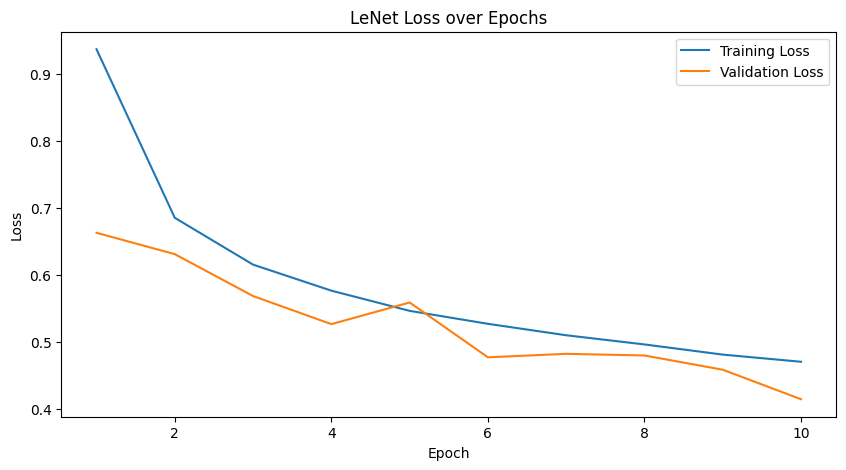

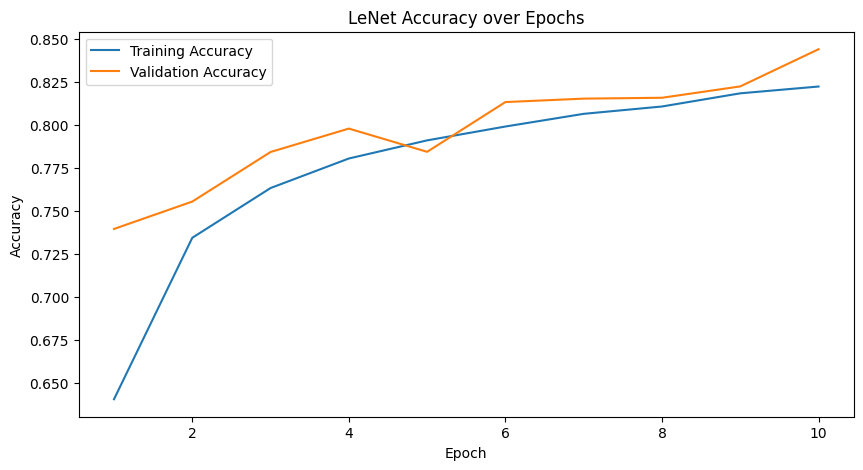

In [34]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LeNet Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('LeNet Accuracy over Epochs')
plt.legend()
plt.show()